In [1]:
# -*- coding: utf-8 -*-
"""
Created by Chris Stewart with help from David Wang
Licensed under GNU GPLv3
---
This code was written as part of the Space Apps Challenge 2020
on Oct 2-4, 2020.

It utilizes prepared MOPITT MOP02J version 8 CSV files in Python 
and generates visualizations of the COTotalColumn data using cartopy.

The CSV data files must be in a directory "/data" at the same level as another directory "/code" where the .ipynb code file must be (your current working directory).

More info can be found in the readme file.
"""
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.feature as cfeature
import ipywidgets as widget

from matplotlib.animation import FuncAnimation, PillowWriter  # for animations
from IPython.display import HTML

In [2]:
full_path = Path(os.getcwd()).parents[0] / 'data' # get path to data files (/data is the same level as /code directory)
file_dict = {} # to store file:path pairs

print('Loading data files...')
for r, _, file in os.walk(full_path): # get all the csvs
    for f in file:
        if f.endswith(".csv"):
            #print(os.path.join(r, f))
            file_dict[f] = os.path.normpath(os.path.join(r, f))

            
# Latitude, Longitude, COTotalColumn,COMixingRatio surface,COMixingRatio 900hPa,COMixingRatio 800hPa,COMixingRatio 700hPa,
# COMixingRatio 600hPa, COMixingRatio 500hPa,COMixingRatio 400hPa,COMixingRatio 300hPa,COMixingRatio 200hPa,
# COMixingRatio 100hPa,RetrievedSurfaceTemperature
data_df = pd.concat((pd.read_csv(r, usecols=['# Latitude',' Longitude',' COTotalColumn','COMixingRatio surface','COMixingRatio surface','COMixingRatio 900hPa','COMixingRatio 600hPa']).assign(Filename = f) for f, r in file_dict.items())) # read CSVs into a dataframe
print('Loading Complete!')



print('Processing...') # create year, month, and day columns
data_df['Date'] = data_df['Filename'].apply(lambda x: x.split('-',maxsplit=2)[1])
data_df['Year'] = data_df['Date'].apply(lambda x: int(x[0:4]))
data_df['Month'] = data_df['Date'].apply(lambda x: int(x[4:6]))
data_df['Day'] = data_df['Date'].apply(lambda x: int(x[6:8]))
data_df.rename(columns = {'# Latitude':'Latitude',' Longitude':'Longitude',' COTotalColumn':'COTotalColumn','COMixingRatio surface':'COMixingRatio_surface','COMixingRatio 900hPa':'COMixingRatio_900hPa','COMixingRatio 600hPa':'COMixingRatio_600hPa'}, inplace = True) # get rid of column header whitespaces
data_df.reset_index(inplace=True)
# set up data for graphing

lat = data_df['Latitude']
long = data_df['Longitude']
COTotalColumn = data_df['COTotalColumn']
COMixingRatio_surface = data_df['COMixingRatio_surface']

print('Processing done!')

Loading data files...
Loading Complete!
Processing...
Processing done!


## The MOPITT Data

In [3]:
data_df # see if data loaded correctly

,index,Latitude,Longitude,COTotalColumn,COMixingRatio_surface,COMixingRatio_900hPa,COMixingRatio_600hPa,Filename,Date,Year,Month,Day
0,0,-77.7472,43.1307,8.265200e+17,132.1690,NaN,140.2030,MOP02J-20200301-L2V18.0.3.csv,20200301,2020,3,1
1,1,-77.8375,44.1249,8.201560e+17,126.9870,NaN,136.1920,MOP02J-20200301-L2V18.0.3.csv,20200301,2020,3,1
2,2,-77.9242,45.1334,6.825480e+17,90.0939,NaN,95.3848,MOP02J-20200301-L2V18.0.3.csv,20200301,2020,3,1
3,3,-78.0073,46.1582,6.219220e+17,77.3387,NaN,81.1695,MOP02J-20200301-L2V18.0.3.csv,20200301,2020,3,1
4,4,-78.1851,42.0651,7.598280e+17,114.3460,NaN,120.0340,MOP02J-20200301-L2V18.0.3.csv,20200301,2020,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5229936,246611,42.0986,-28.4305,2.072760e+18,116.8890,112.897,102.0870,MOP02J-20200322-L2V18.0.3.csv,20200322,2020,3,22
5229937,246612,42.0544,-28.9660,2.038830e+18,114.4640,108.333,96.5153,MOP02J-20200322-L2V18.0.3.csv,20200322,2020,3,22
5229938,246613,43.1304,-26.6990,2.004040e+18,114.4150,105.830,92.3123,MOP02J-20200322-L2V18.0.3.csv,20200322,2020,3,22
5229939,246614,43.2075,-27.0174,2.030990e+18,118.6120,115.919,103.5500,MOP02J-20200322-L2V18.0.3.csv,20200322,2020,3,22


In [4]:
# create a summary dataframe of unique year, month, day values for easy indexing later
dateIndex_df = data_df.groupby(['Year','Month','Day']).size().reset_index().rename(columns={0:'Count'})
dateIndex_df

,Year,Month,Day,Count
0,2020,3,1,240730
1,2020,3,2,234245
2,2020,3,3,239783
3,2020,3,4,246627
4,2020,3,5,242179
5,2020,3,6,237693
6,2020,3,7,224807
7,2020,3,8,223772
8,2020,3,9,226477
9,2020,3,10,228772


In [5]:
data_df[(data_df['Year']==2020) & (data_df['Month']==3) & (data_df['Day']>=1) & (data_df['Day']<=5)]

,index,Latitude,Longitude,COTotalColumn,COMixingRatio_surface,COMixingRatio_900hPa,COMixingRatio_600hPa,Filename,Date,Year,Month,Day
0,0,-77.7472,43.1307,8.265200e+17,132.1690,NaN,140.2030,MOP02J-20200301-L2V18.0.3.csv,20200301,2020,3,1
1,1,-77.8375,44.1249,8.201560e+17,126.9870,NaN,136.1920,MOP02J-20200301-L2V18.0.3.csv,20200301,2020,3,1
2,2,-77.9242,45.1334,6.825480e+17,90.0939,NaN,95.3848,MOP02J-20200301-L2V18.0.3.csv,20200301,2020,3,1
3,3,-78.0073,46.1582,6.219220e+17,77.3387,NaN,81.1695,MOP02J-20200301-L2V18.0.3.csv,20200301,2020,3,1
4,4,-78.1851,42.0651,7.598280e+17,114.3460,NaN,120.0340,MOP02J-20200301-L2V18.0.3.csv,20200301,2020,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1203559,242174,-26.0964,156.9720,1.315830e+18,51.2173,51.6176,59.4268,MOP02J-20200305-L2V18.0.3.csv,20200305,2020,3,5
1203560,242175,-26.7593,156.5880,1.196110e+18,53.5568,55.7860,61.2281,MOP02J-20200305-L2V18.0.3.csv,20200305,2020,3,5
1203561,242176,-26.5385,156.6210,1.305520e+18,52.4025,53.3907,60.9404,MOP02J-20200305-L2V18.0.3.csv,20200305,2020,3,5
1203562,242177,-26.7130,156.0530,1.248950e+18,46.9785,41.8667,39.3838,MOP02J-20200305-L2V18.0.3.csv,20200305,2020,3,5


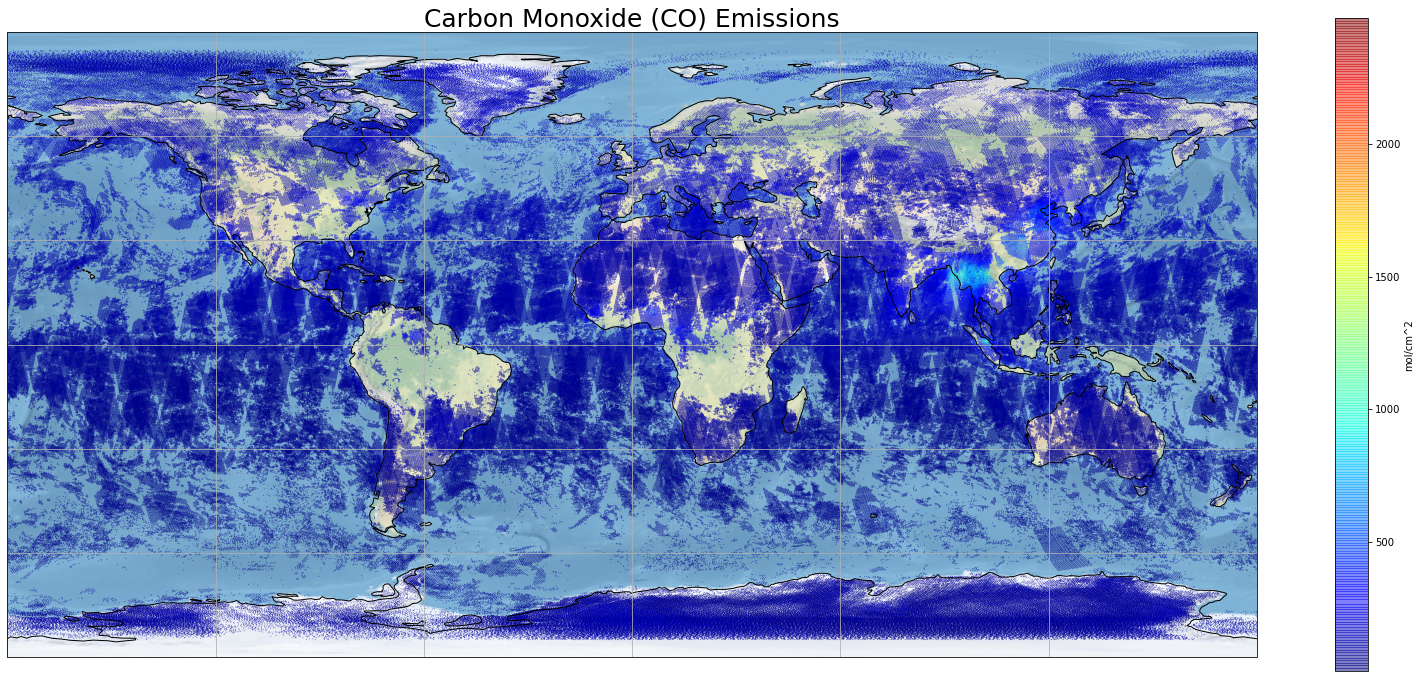

In [6]:
#%matplotlib notebook - disable interactivity for now

# PLOT ONE 5-DAY CHUNK TO TEST

fig = plt.figure(figsize=(28,12))

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree()) #.Robinson()) - alternate projection
# add details and features to map
ax.stock_img()
ax.coastlines()
ax.gridlines()

i = data_df[(data_df['Year']==2020) & (data_df['Month']==3) & (data_df['Day']>=11) & (data_df['Day']<=15)].index

plt.scatter(x=long.iloc[i], y=lat.iloc[i], #long, y=lat,   #
            c=COMixingRatio_surface.iloc[i], # Alternative -> COTotalColumn.iloc[i],
            s=1,
            alpha=0.5,
            cmap=plt.cm.jet,
            edgecolors=None, 
            linewidth=0,
            transform=crs.PlateCarree()) ## Important

#fig.colorbar(cm.ScalarMappable(norm=norm, cmap=plt.cm.jet))#, ax=ax)

cb = plt.colorbar()
cb.set_label('mol/cm^2')

plt.title('Carbon Monoxide (CO) Emissions', size=25)

plt.show()